<a href="https://colab.research.google.com/github/cedric-bit/MLP/blob/main/thesis3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:301: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:301: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\MFE\AppData\Local\Temp\ipykernel_12312\3222025019.py:301: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if data.size is 0:


TDMS Reader demo.
File: laach_UTC_20210701_125929.386.tdms
Number of channels in file: 640
Time samples in file: 160000
Sampling frequency (Hz): 8000.0
Size of data loaded: (50001, 520)


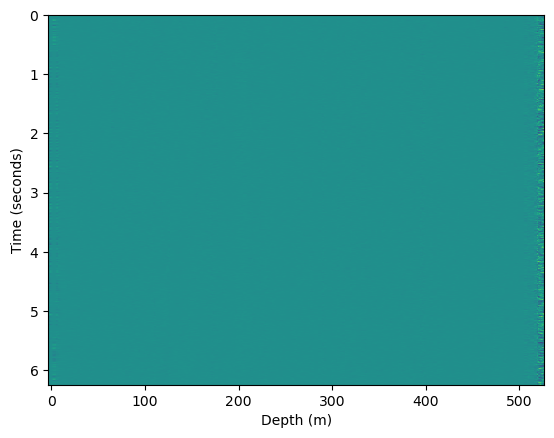

In [ ]:
# -*- coding: utf-8 -*-
"""
Copyright (c) 2018 Silixa Ltd
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation
files (the "Software"), to use the Software for the sole purpose of private, non-commercial use and/or in-house company
research and development meaning the right to use, copy, modify, merge, share the Software, and to permit persons to whom
the Software is furnished to like-wise do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
For any intended commercial use then contact the copyright holder, Silixa Ltd, for permission, which shall not be unreasonably
withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR
IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

$Rev:: 26283                                                                  $
$Date:: 2018-03-27 13:14:05 +0100 (Tue, 27 Mar 2018)                          $

Ref:    [1] TDMS_Adv_Read.m
        [2] http://www.ni.com/white-paper/5696/en#toc2

"""

import os, struct, datetime
import pandas as pd
import numpy as np
import mmap

def load_property_map(xls_file):
    prop_map = pd.read_excel(xls_file, sheetname='Sheet1')
    return prop_map[['CurrentTag', 'CorrectTag']].applymap(lambda x: x.replace(" ", "")).set_index('CurrentTag').to_dict()['CorrectTag']

#prop_map = load_property_map('MetaDataTable_iDAS_TDMS_CFG_Tags.xlsx')

def write_property_dict(prop_dict, out_file):
    from pprint import pformat
    f = open(out_file, 'w')
    f.write('tdms_property_map=')
    f.write(pformat(prop_dict))
    f.close()

def type_not_supported(vargin):
    """Function raises a NotImplementedException."""
    raise NotImplementedError("Reading of this tdsDataType is not implemented")


def parse_time_stamp(fractions, seconds):
    """
    Convert time TDMS time representation to datetime
    fractions   -- fractional seconds (2^-64)
    seconds     -- The number of seconds since 1/1/1904
    @rtype : datetime.datetime
    """
    if fractions is not None and seconds is not None and fractions + seconds > 0:
        return datetime.timedelta(0, fractions * 2 ** -64 + seconds) + \
               datetime.datetime(1904, 1, 1)
    else:
        return None


# Enum mapping TDM data types to description string, numpy type where exists
# See Ref[2] for enum values
TDS_DATA_TYPE = dict({
    0x00: 'void', # tdsTypeVoid
    0x01: 'int8', # tdsTypeI8
    0x02: 'int16', # tdsTypeI16
    0x03: 'int32', # tdsTypeI32
    0x04: 'int64', # tdsTypeI64
    0x05: 'uint8', # tdsTypeU8
    0x06: 'uint16', # tdsTypeU16
    0x07: 'uint32', # tdsTypeU32
    0x08: 'uint64', # tdsTypeU64
    0x09: 'float32', # tdsTypeSingleFloat
    0x0a: 'float64', # tdsTypeDoubleFloat
    0x0b: 'float128', # tdsTypeExtendedFloat
    0x19: 'singleFloatWithUnit', # tdsTypeSingleFloatWithUnit
    0x1a: 'doubleFloatWithUnit', # tdsTypeDoubleFloatWithUnit
    0x1b: 'extendedFloatWithUnit', # tdsTypeExtendedFloatWithUnit
    0x20: 'str', # tdsTypeString
    0x21: 'bool', # tdsTypeBoolean
    0x44: 'datetime', # tdsTypeTimeStamp
    0xFFFFFFFF: 'raw'               # tdsTypeDAQmxRawData
})

# Function mapping for reading TDMS data types
TDS_READ_VAL = dict({
    'void': lambda f: None, # tdsTypeVoid
    'int8': lambda f: struct.unpack('<b', f.read(1))[0],
    'int16': lambda f: struct.unpack('<h', f.read(2))[0],
    'int32': lambda f: struct.unpack('<i', f.read(4))[0],
    'int64': lambda f: struct.unpack('<q', f.read(8))[0],
    'uint8': lambda f: struct.unpack('<B', f.read(1))[0],
    'uint16': lambda f: struct.unpack('<H', f.read(2))[0],
    'uint32': lambda f: struct.unpack('<I', f.read(4))[0],
    'uint64': lambda f: struct.unpack('<Q', f.read(8))[0],
    'float32': lambda f: struct.unpack('<f', f.read(4))[0],
    'float64': lambda f: struct.unpack('<d', f.read(8))[0],
    'float128': type_not_supported,
    'singleFloatWithUnit': type_not_supported,
    'doubleFloatWithUnit': type_not_supported,
    'extendedFloatWithUnit': type_not_supported,
    'str': lambda f: f.read(struct.unpack('<i', f.read(4))[0]),
    'bool': lambda f: struct.unpack('<?', f.read(1))[0],
    'datetime': lambda f: parse_time_stamp(
        struct.unpack('<Q', f.read(8))[0], struct.unpack('<q', f.read(8))[0]),
    'raw': type_not_supported
})

DECIMATE_MASK = 0b00100000
LEAD_IN_LENGTH = 28
FILEINFO_NAMES = ('file_tag',
                  'toc',
                  'version',
                  'next_segment_offset',
                  'raw_data_offset')


class TdmsReader(object):
    """A TDMS file reader object for reading properties and data"""

    def __init__(self, filename):
        self._properties = None
        self._end_of_properties_offset = None
        self._data_type = None
        self._chunk_size = None

        self._raw_data = None
        self._raw_data2 = None # The mapped data in the 'Next Segment'
        self._raw_last_chunk = None
        self._raw2_last_chunk = None

        self.file_size = os.path.getsize(filename)
        self._channel_length = None
        self._seg1_length = None
        self._seg2_length = None

        #TODO: Error if file not big enough to hold header
        self._tdms_file = open(filename, 'rb')
        # Read lead in (28 bytes):
        lead_in = self._tdms_file.read(LEAD_IN_LENGTH)
        # lead_in is 28 bytes:
        # [string of length 4][int32][int32][int64][int64]
        fields = struct.unpack('<4siiQQ', lead_in)

        #TODO: validate file
        if fields[0].decode() not in 'TDSm':
            msg = "Not a TDMS file (TDSm tag not found)"
            raise(TypeError, msg)

        self.fileinfo = dict(zip(FILEINFO_NAMES, fields))
        self.fileinfo['decimated'] = not bool(self.fileinfo['toc'] &
                                              DECIMATE_MASK)
        # Make offsets relative to beginning of file:
        self.fileinfo['next_segment_offset'] += LEAD_IN_LENGTH
        self.fileinfo['raw_data_offset'] += LEAD_IN_LENGTH
        self.fileinfo['file_size'] = os.path.getsize(self._tdms_file.name)

        #TODO: Validate lead in:
        if self.fileinfo['next_segment_offset'] > self.file_size:
            self.fileinfo['next_segment_offset'] = self.file_size
            # raise(ValueError, "Next Segment Offset too large in TDMS header")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self._tdms_file.close()

    def _get_channel_length(self):
        if not self._channel_length:
            self._initialise_data()

        return self._channel_length

    channel_length = property(_get_channel_length)

    def get_properties(self, mapped=False):
        """
        Return a dictionary of properties. Read from file only if necessary.
        """
        # Check if already hold properties in memory
        if self._properties is None:
            self._properties = self._read_properties()
        if mapped:
            props = self._properties.copy()
            tmp = [prop_map.get(col.replace(" ", ""),col.replace(" ", "")) for col in self._properties.index]
            tmp1 = []
            def addToList(ls, val, cnt=0):
                if val not in ls:
                    ls.append(val)
                else:
                    newVal = val + '_' + str(cnt+1)
                    if newVal not in ls:
                        ls.append(newVal)
                    else:
                        addToList(ls, val, cnt+1)

            for col in tmp:
                addToList(tmp1, col)

            props.index = tmp1
            return props.loc[:,'Value'].to_dict()
        else:
            return self._properties.loc[:,'Value'].to_dict()

    def _read_property(self):
        """
        Read a single property from the TDMS file.
        Return the name, type and value of the property as a list.
        """
        # Read length of object path:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        # Read property name and type:
        name, data_type = struct.unpack('<{0}si'.format(var),
                                        self._tdms_file.read(var + 4))
        # Lookup function to read and parse property value based on type:
        value = TDS_READ_VAL[TDS_DATA_TYPE[data_type]](self._tdms_file)
        name = name.decode()
        if data_type == 32:
            value = value.decode()

        return name, data_type, value

    def _read_properties(self):
        """Read the properties from the file"""
        self._tdms_file.seek(LEAD_IN_LENGTH, 0)
        # Number of channels is total objects - file objects - group objects
        self.fileinfo['n_channels'] = struct.unpack('i',
                                                    self._tdms_file.read(4))[0] - 2
        # Read length of object path:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        # skip over object path and raw data index:
        self._tdms_file.seek(var + 4, 1)
        # Read number of properties in this group:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]

        # loop through and read each property
        properties = [self._read_property() for _ in range(var)]
        df = pd.DataFrame(properties)
        df.columns = ['Property', 'Type', 'Value']
        df.set_index('Property', inplace=True)

        self._end_of_properties_offset = self._tdms_file.tell()

        self._read_chunk_size()
        #TODO: Add number of channels to properties
        return df

    def _read_chunk_size(self):
        """ Read the data chunk size from the TDMS file header."""
        if self._end_of_properties_offset is None:
            self._read_properties()

        self._tdms_file.seek(self._end_of_properties_offset, 0)

        # skip over Group Information:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        self._tdms_file.seek(var + 8, 1)

        # skip over first channel path and length of index information:
        var = struct.unpack('<i', self._tdms_file.read(4))[0]
        self._tdms_file.seek(var + 4, 1)

        self._data_type = TDS_DATA_TYPE.get(
            struct.unpack('<i', self._tdms_file.read(4))[0])
        if self._data_type not in ('int16', 'float32'):
            raise Exception('Unsupported TDMS data type: ' + self._data_type)

        # Read Dimension of the raw data array (has to be 1):
        dummy = struct.unpack('<i', self._tdms_file.read(4))[0]

        self._chunk_size = struct.unpack('<i', self._tdms_file.read(4))[0]

    def get_data(self, first_ch=0, last_ch=None, first_s=0, last_s=None):
        """
        Get a block of data from the TDMS file.
        first_ch -- The first channel to load
        last_ch  -- The last channel to load
        first_s  -- The first sample to load
        last_s   -- The last sample to load
        """
        if self._raw_data is None:
            self._initialise_data()
        if first_ch is None or first_ch < 0:
            first_ch = 0
        if last_ch is None or last_ch >= self.fileinfo['n_channels']:
            last_ch = self.fileinfo['n_channels']
        else:
            # return data inclusive of last_ch, numpy indexing is exclusive of end index
            last_ch += 1
        if last_s is None or last_s > self._channel_length:
            last_s = self._channel_length
        else:
            # return data inclusive of last_s, numpy indexing is exclusive of end index
            last_s += 1
        nch = int(max(last_ch - first_ch, 0))
        ns = int(max(last_s - first_s, 0))

        # Allocate output container
        data = np.empty((ns, nch), dtype=np.dtype(self._data_type))
        if data.size is 0:
            return data

        ## 1. Index first block & reshape?
        first_blk = first_s // self._chunk_size
        last_blk = last_s // self._chunk_size
        last_full_blk = min(last_blk + 1, self._raw_data.shape[1])
        nchunk = min(max(last_full_blk - first_blk, 0), self._raw_data.shape[1])
        first_s_1a = max(first_s - first_blk * self._chunk_size, 0)
        last_s_1a = min(last_s - first_blk * self._chunk_size, nchunk*self._chunk_size)
        ind_s = 0
        ind_e = ind_s + max(last_s_1a - first_s_1a, 0)

        # data_1a = self._raw_data[:, first_blk:last_full_blk,
        #             first_ch:last_ch].reshape((self._chunk_size*nchunk, nch), order='F')[first_s_1a:last_s_1a, :]
        d = self._raw_data[:, first_blk:last_full_blk,
                    first_ch:last_ch]
        d.shape = (self._chunk_size*nchunk, nch)
        d.reshape((self._chunk_size*nchunk, nch), order='F')
        data[ind_s:ind_e,:] = d[first_s_1a:last_s_1a, :]

        ## 2. Index first additional samples
        first_s_1b = max(first_s - self._raw_data.shape[1]*self._chunk_size, 0)
        last_s_1b = min(last_s - self._raw_data.shape[1]*self._chunk_size, self._raw_last_chunk.shape[0])
        ind_s = ind_e
        ind_e = ind_s + max(last_s_1b - first_s_1b, 0)
        # data_1b = self._raw_last_chunk[first_s_1b:last_s_1b,first_ch:last_ch]
        if ind_e > ind_s:
            data[ind_s:ind_e,:] = self._raw_last_chunk[first_s_1b:last_s_1b,first_ch:last_ch]

        ## 3. Index second block
        first_s_2 = max(first_s - self._seg1_length, 0)
        last_s_2 = last_s - self._seg1_length
        if (first_s_2 > 0 or last_s_2 > 0) and self._raw_data2 is not None:
            first_blk_2 = max(first_s_2 // self._chunk_size, 0)
            last_blk_2 = max(last_s_2 // self._chunk_size, 0)
            last_full_blk_2 = min(last_blk_2 + 1, self._raw_data2.shape[1])
            nchunk_2 = min(max(last_full_blk_2 - first_blk_2, 0), self._raw_data2.shape[1])
            first_s_2a = max(first_s_2 - first_blk_2 * self._chunk_size, 0)
            last_s_2a = min(last_s_2 - first_blk_2 * self._chunk_size, nchunk_2*self._chunk_size)
            ind_s = ind_e
            ind_e = ind_s + max(last_s_2a - first_s_2a, 0)
            # data_2a = self._raw_data2[:, first_blk_2:last_full_blk_2,
            #             first_ch:last_ch].reshape((self._chunk_size*nchunk_2, nch), order='F')[first_s_2a:last_s_2a, :]
            if ind_e > ind_s:
                data[ind_s:ind_e,:] = self._raw_data2[:, first_blk_2:last_full_blk_2,
                        first_ch:last_ch].reshape((self._chunk_size*nchunk_2, nch), order='F')[first_s_2a:last_s_2a, :]
        ## 4. Index second additional samples
        if (first_s_2 > 0 or last_s_2 > 0) and self._raw2_last_chunk is not None:
            first_s_2b = max(first_s_2 - self._raw_data2.shape[1]*self._chunk_size, 0)
            last_s_2b = min(last_s_2 - self._raw_data2.shape[1]*self._chunk_size, self._raw2_last_chunk.shape[0])
            ind_s = ind_e
            ind_e = ind_s + max(last_s_2b - first_s_2b, 0)
            # data_2b = self._raw2_last_chunk[first_s_2b:last_s_2b,first_ch:last_ch]
            if ind_e > ind_s:
                data[ind_s:ind_e,:] = self._raw2_last_chunk[first_s_2b:last_s_2b,first_ch:last_ch]
        ## 5. Concatenate blocks
        # data = np.concatenate((data_1a, data_1b, data_2a, data_2b))
        if data.size == 0:
            data = data.reshape(0,0)
        return data

    def _initialise_data(self):
        """Initialise the memory map for the data array."""
        if self._chunk_size is None:
            self._read_chunk_size()

        dmap = mmap.mmap(self._tdms_file.fileno(), 0, access=mmap.ACCESS_READ)
        rdo = int(self.fileinfo['raw_data_offset'])
        nch = int(self.fileinfo['n_channels'])

        #TODO: Support streaming file type?
        #TODO: Is this a valid calculation for ChannelLength?
        nso = self.fileinfo['next_segment_offset']
        self._seg1_length = int((nso - rdo) / nch / np.dtype(self._data_type).itemsize)
        self._channel_length = self._seg1_length

        if self.fileinfo['decimated']:
            n_complete_blk = int(self._seg1_length / self._chunk_size)
            ax_ord = 'C'
        else:
            n_complete_blk = 0
            ax_ord = 'F'
        self._raw_data = np.ndarray((n_complete_blk, nch, self._chunk_size),
                                    dtype=self._data_type,
                                    buffer=dmap,
                                    offset=rdo)
        # Rotate the axes to [chunk_size, nblk, nch]
        self._raw_data = np.rollaxis(self._raw_data, 2)
        additional_samples = int(self._seg1_length - n_complete_blk * self._chunk_size)
        additional_samples_offset = rdo + n_complete_blk*nch*self._chunk_size*np.dtype(self._data_type).itemsize
        self._raw_last_chunk = np.ndarray((nch, additional_samples),
                                    dtype=self._data_type,
                                    buffer=dmap,
                                    offset=additional_samples_offset,
                                    order=ax_ord)
        # Rotate the axes to [samples, nch]
        self._raw_last_chunk = np.rollaxis(self._raw_last_chunk, 1)

        if self.file_size == nso:
            self._seg2_length = 0
        else:
            self._tdms_file.seek(nso + 12, 0)
            (seg2_nso, seg2_rdo) = struct.unpack('<qq',
                                                 self._tdms_file.read(2 * 8))
            self._seg2_length = (seg2_nso - seg2_rdo) / nch / np.dtype(self._data_type).itemsize
            if self.fileinfo['decimated']:
                n_complete_blk2 = int(self._seg2_length / self._chunk_size)
            else:
                n_complete_blk2 = int(0)
            self._raw_data2 = np.ndarray((n_complete_blk2, nch, self._chunk_size),
                                         dtype=self._data_type,
                                         buffer=dmap,
                                         offset=(nso + LEAD_IN_LENGTH + seg2_rdo))
            self._raw_data2 = np.rollaxis(self._raw_data2, 2)
            additional_samples = int(self._seg2_length - n_complete_blk2 * self._chunk_size)
            additional_samples_offset = nso + LEAD_IN_LENGTH + seg2_rdo + n_complete_blk2*nch*self._chunk_size*np.dtype(self._data_type).itemsize
            self._raw2_last_chunk = np.ndarray((nch, additional_samples),
                                    dtype=self._data_type,
                                    buffer=dmap,
                                    offset=additional_samples_offset,
                                    order=ax_ord)
            # Rotate the axes to [samples, nch]
            self._raw2_last_chunk = np.rollaxis(self._raw2_last_chunk, 1)

            if self._raw_data2.size != 0 or self._raw2_last_chunk.size != 0:
                pass
                # raise Exception('Second segment contains some data, \
                #                 not currently supported')
            self._channel_length = self._seg1_length + self._seg2_length
        # else:
        #     print "Not decimated"
        #     raise Exception('Reading file with decimated flag not set is not \
        #                     supported yet')


if __name__ == '__main__':
    print("TDMS Reader demo.")

    file_path = 'laach_UTC_20210701_125929.386.tdms'

    print('File: {0}'.format(file_path))

    tdms = TdmsReader(file_path)

    props = tdms.get_properties()

    zero_offset = props.get('Zero Offset (m)')
    channel_spacing = props.get('SpatialResolution[m]') * props.get('Fibre Length Multiplier')
    n_channels = tdms.fileinfo['n_channels']
    depth = zero_offset + np.arange(n_channels) * channel_spacing
    fs = props.get('SamplingFrequency[Hz]')

    print('Number of channels in file: {0}'.format(n_channels))
    print('Time samples in file: {0}'.format(tdms.channel_length))
    print('Sampling frequency (Hz): {0}'.format(fs))

    first_channel = 120
    last_channel = 639
    first_time_sample = 0
    last_time_sample = 50000 # modifier jusqu'au dernier sample ( echattilon)


    some_data = tdms.get_data(first_channel, last_channel, first_time_sample, last_time_sample)
    print('Size of data loaded: {0}'.format(some_data.shape))

    import matplotlib.pyplot as plt

    fig1 = plt.figure()
    img1 = plt.imshow(some_data, aspect='auto', interpolation='none', extent=(depth[first_channel],depth[last_channel], last_time_sample/fs, first_time_sample/fs))
    plt.ylabel('Time (seconds)')
    plt.xlabel('Depth (m)')
    plt.show(block=False)


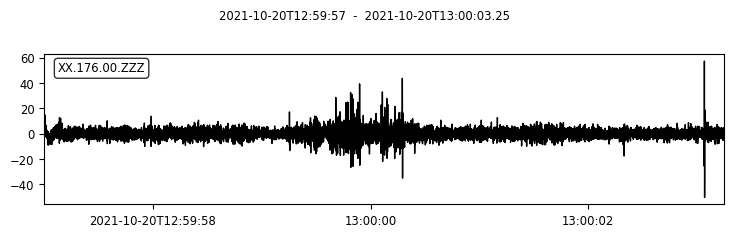

In [ ]:
from obspy import UTCDateTime,Stream,Trace

# Initialiser un Stream vide pour ObsPy
stream = Stream()

# Initialiser l'horodatage de départ
start_time =  start_time = UTCDateTime(2021, 10, 20, 12, 59, 1)
  # Utilisez l'horodatage de départ actuel

# Parcourir chaque canal et traiter les données
for channel in range(first_channel, last_channel + 1):
    data = tdms.get_data(channel, channel, first_time_sample, last_time_sample)
    data = data.flatten()

    # Créer les métadonnées pour le fichier MiniSEED
    stats = {
        'network': 'XX',
        'station': str(channel),
        'location': '00',
        'channel': 'ZZZ',
        'npts': len(data),
        'sampling_rate': fs,
        'starttime': start_time,  # Utilisez l'horodatage de départ mis à jour
        'mseed': {'dataquality': 'D'}
    }

    # Ajouter les données à Stream
    stream += Trace(data=data, header=stats)

    # Mettre à jour l'horodatage de départ pour la prochaine trace
    start_time += 1  # Ajoutez 0,8 seconde à l'horodatage de départ
# Traitement et visualisation des données
stream.merge(method=1)
stream.detrend("linear")
# stream.filter('bandpass', freqmin=5, freqmax=200) bubbles we want
#stream.filter(type="highpass", freq=1.0)
stream.filter('bandpass', freqmin=5, freqmax=400)
# Tracez les canaux au indices 10, 11, et 12
stream[56].plot(rasterized=True)

# Écriture du Stream au format MiniSEED
stream.write("scattering_stream.mseed", format="MSEED")


In [ ]:
print(stream)

520 Trace(s) in Stream:

XX.120.00.ZZZ | 2021-10-20T12:59:01.000000Z - 2021-10-20T12:59:07.250000Z | 8000.0 Hz, 50001 samples
...
(518 other traces)
...
XX.639.00.ZZZ | 2021-10-20T13:07:40.000000Z - 2021-10-20T13:07:46.250000Z | 8000.0 Hz, 50001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [ ]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pickle

import numpy as np
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scatseisnet import ScatteringNetwork


In [ ]:
segment_duration_seconds = 20.0
sampling_rate_hertz = 400.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)

In [ ]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=8000, sampling_rate=400.0, len=2)
ComplexMorletBank(bins=8000, octaves=4, resolution=4, quality=1, sampling_rate=400.0, len=16)
ComplexMorletBank(bins=8000, octaves=5, resolution=2, quality=3, sampling_rate=400.0, len=10)


In [ ]:
dirpath_save = "network"

# Create directory to save the results
os.makedirs(dirpath_save, exist_ok=True)

# Save the scattering network with Pickle
filepath_save = os.path.join(dirpath_save, "scattering_network.pickle")
with open(filepath_save, "wb") as file_save:
    pickle.dump(network, file_save, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import numpy as np
import matplotlib.dates as mdates


# Calculez le nombre d'échantillons par segment pour la nouvelle fréquence d'échantillonnage
samples_per_segment = int(segment_duration * sampling_rate)

# Listes pour les timestamps et les segments
timestamps = []
segments = []

# Traitement des traces
for trace in stream:
    # Ici, vous devrez peut-être rééchantillonner 'trace.data' pour correspondre à la nouvelle fréquence d'échantillonnage

    # Découpage en segments
    for start_idx in range(0, len(trace.data), int(samples_per_segment * (1 - overlap))):
        end_idx = start_idx + samples_per_segment

        # Vérifiez si la fin de la trace a été atteinte
        if end_idx > len(trace.data):
            break

        # Extraire le segment et l'ajouter à la liste
        segment = trace.data[start_idx:end_idx]
        segments.append(segment)

        # Ajouter le timestamp correspondant
        timestamp = mdates.num2date(trace.times("matplotlib")[start_idx])
        timestamps.append(timestamp)

# Conversion en tableau numpy, si nécessaire
segments_array = np.array(segments, dtype=object)  # Utilisez dtype=object pour les tableaux de taille inégale


In [ ]:
for s in segments:
    print(s.shape)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


In [ ]:
print(len(timestamps))
#print(timestamps)

5720


In [ ]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)
#print(scattering_coefficients)


In [ ]:
print(scattering_coefficients[1].shape)


(5720, 16, 10)


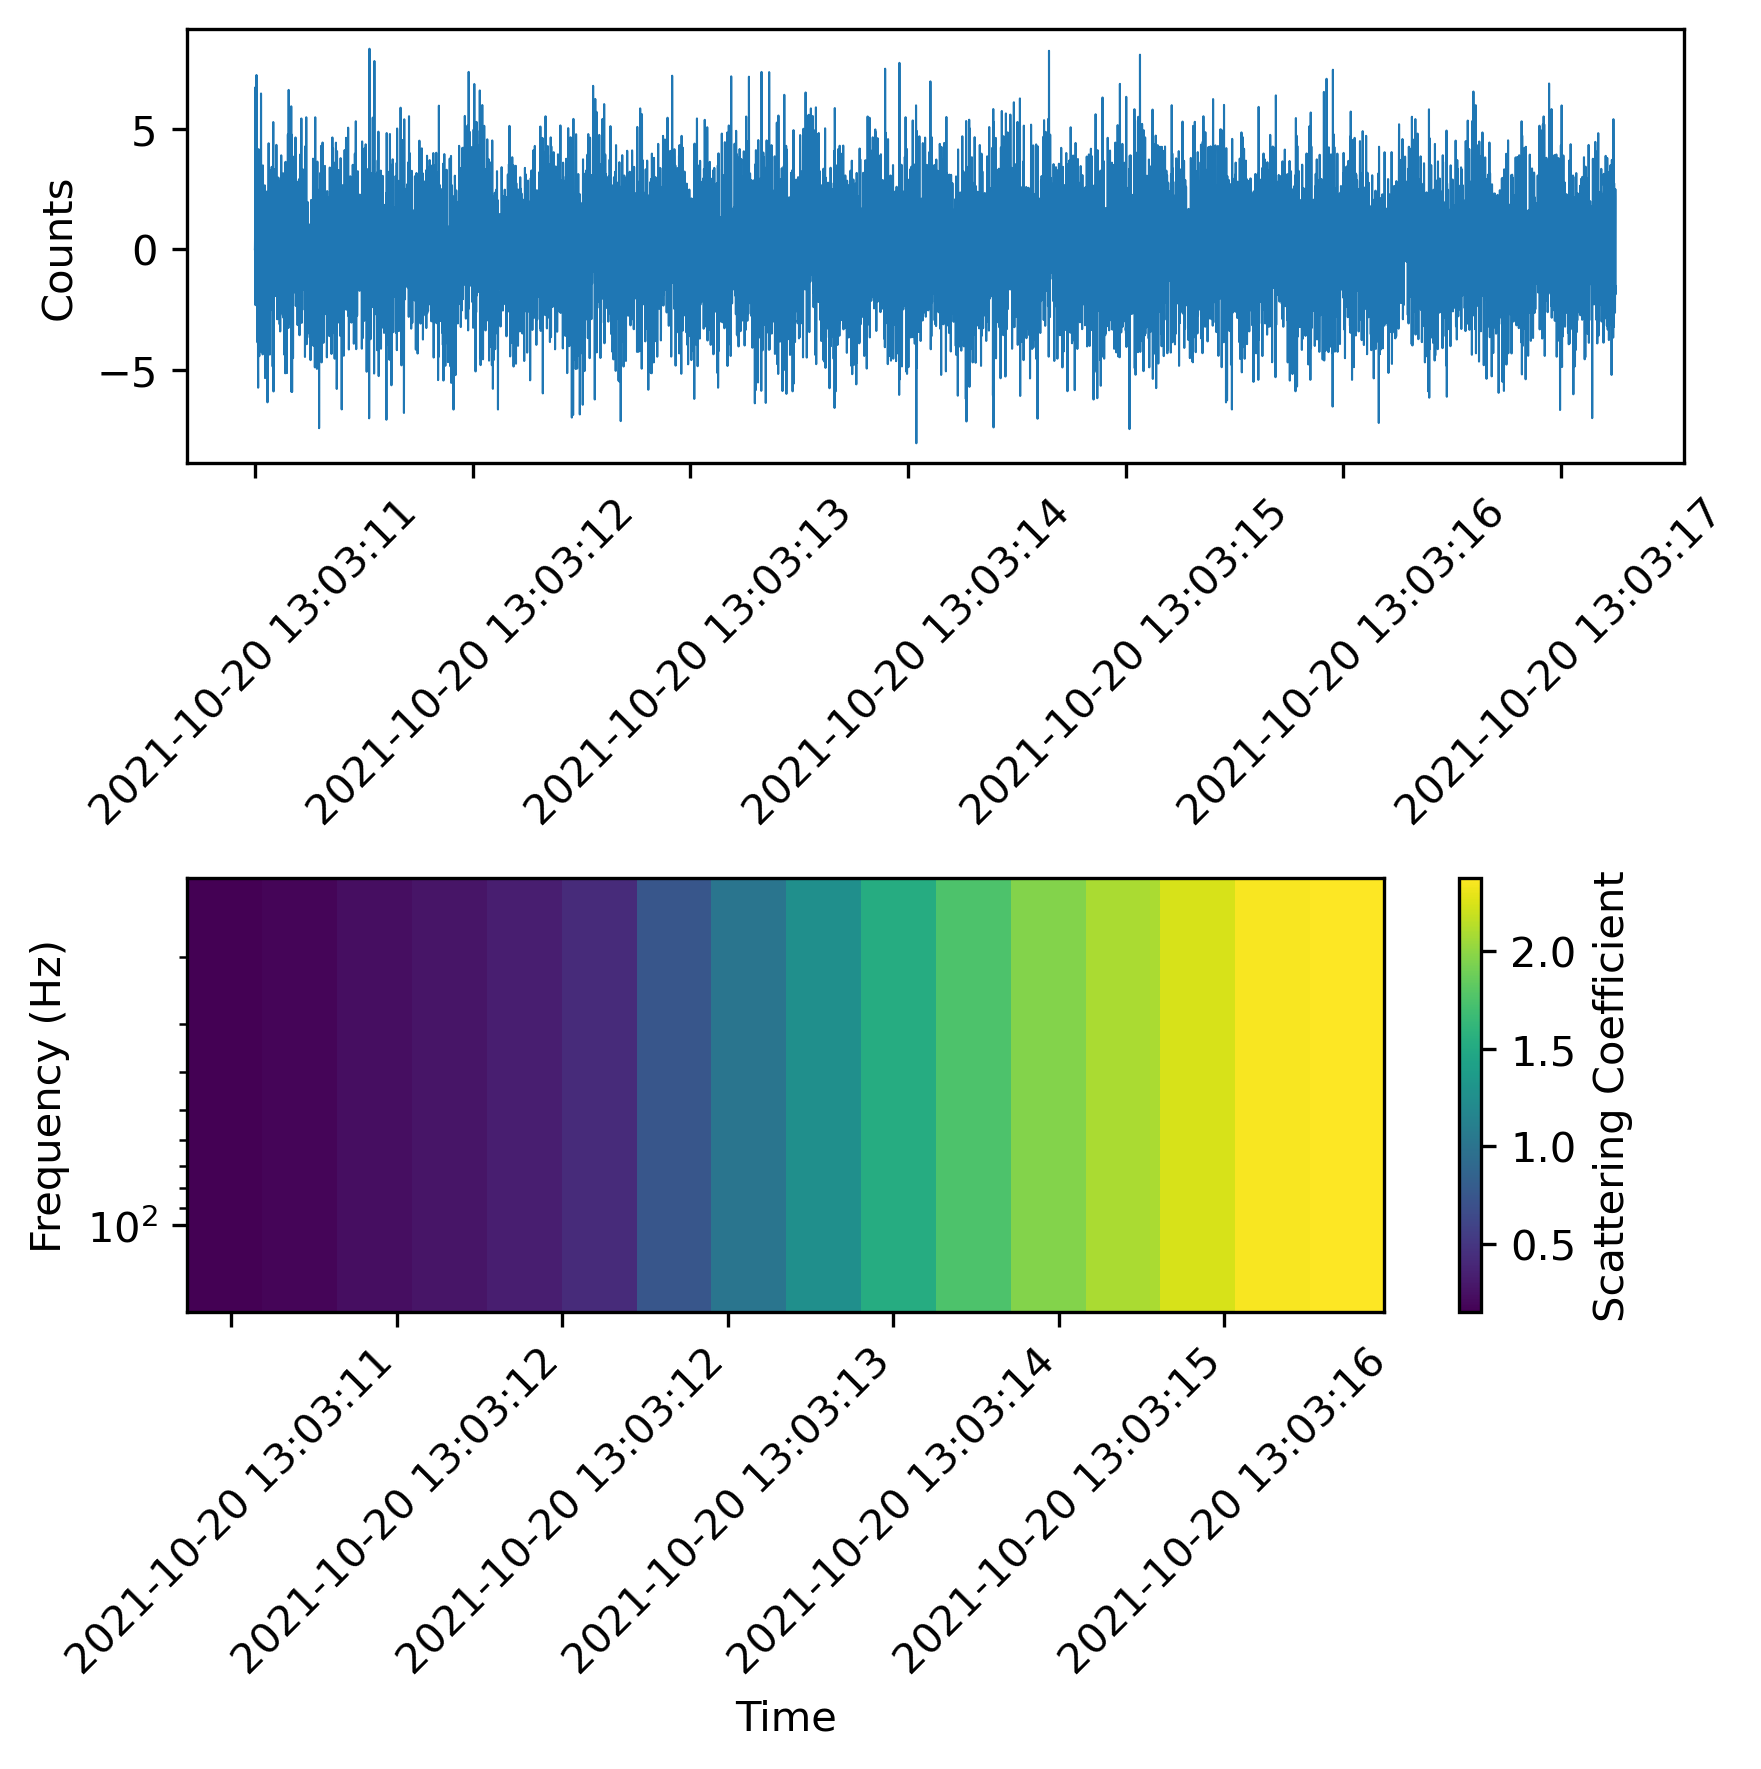

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Extraction du premier canal
channel_id = 250
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id])
center_frequencies = network.banks[0].centers
timestamps = mdates.num2date(trace.times("matplotlib"))

# Création de la figure et des axes
fig, ax = plt.subplots(2, dpi=300, figsize=(6, 6))

# Tracé de la forme d'onde
ax[0].plot(timestamps, trace.data, rasterized=True, lw=0.5)

# Tracé des coefficients de diffusion
order_1_2d = order_1[np.newaxis, :]
extent = [mdates.date2num(timestamps[0]), mdates.date2num(timestamps[-1]), center_frequencies[0], center_frequencies[-1]]
im = ax[1].imshow(order_1_2d, aspect='auto', cmap='viridis', origin='lower', extent=extent)

# Étiquettes des axes
ax[1].set_yscale("log")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
fig.colorbar(im, ax=ax[1], label="Scattering Coefficient")

# Formatage de l'axe des x pour les dates
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.setp(ax[1].get_xticklabels(), rotation=45)

# Affichage
plt.tight_layout()
plt.show()


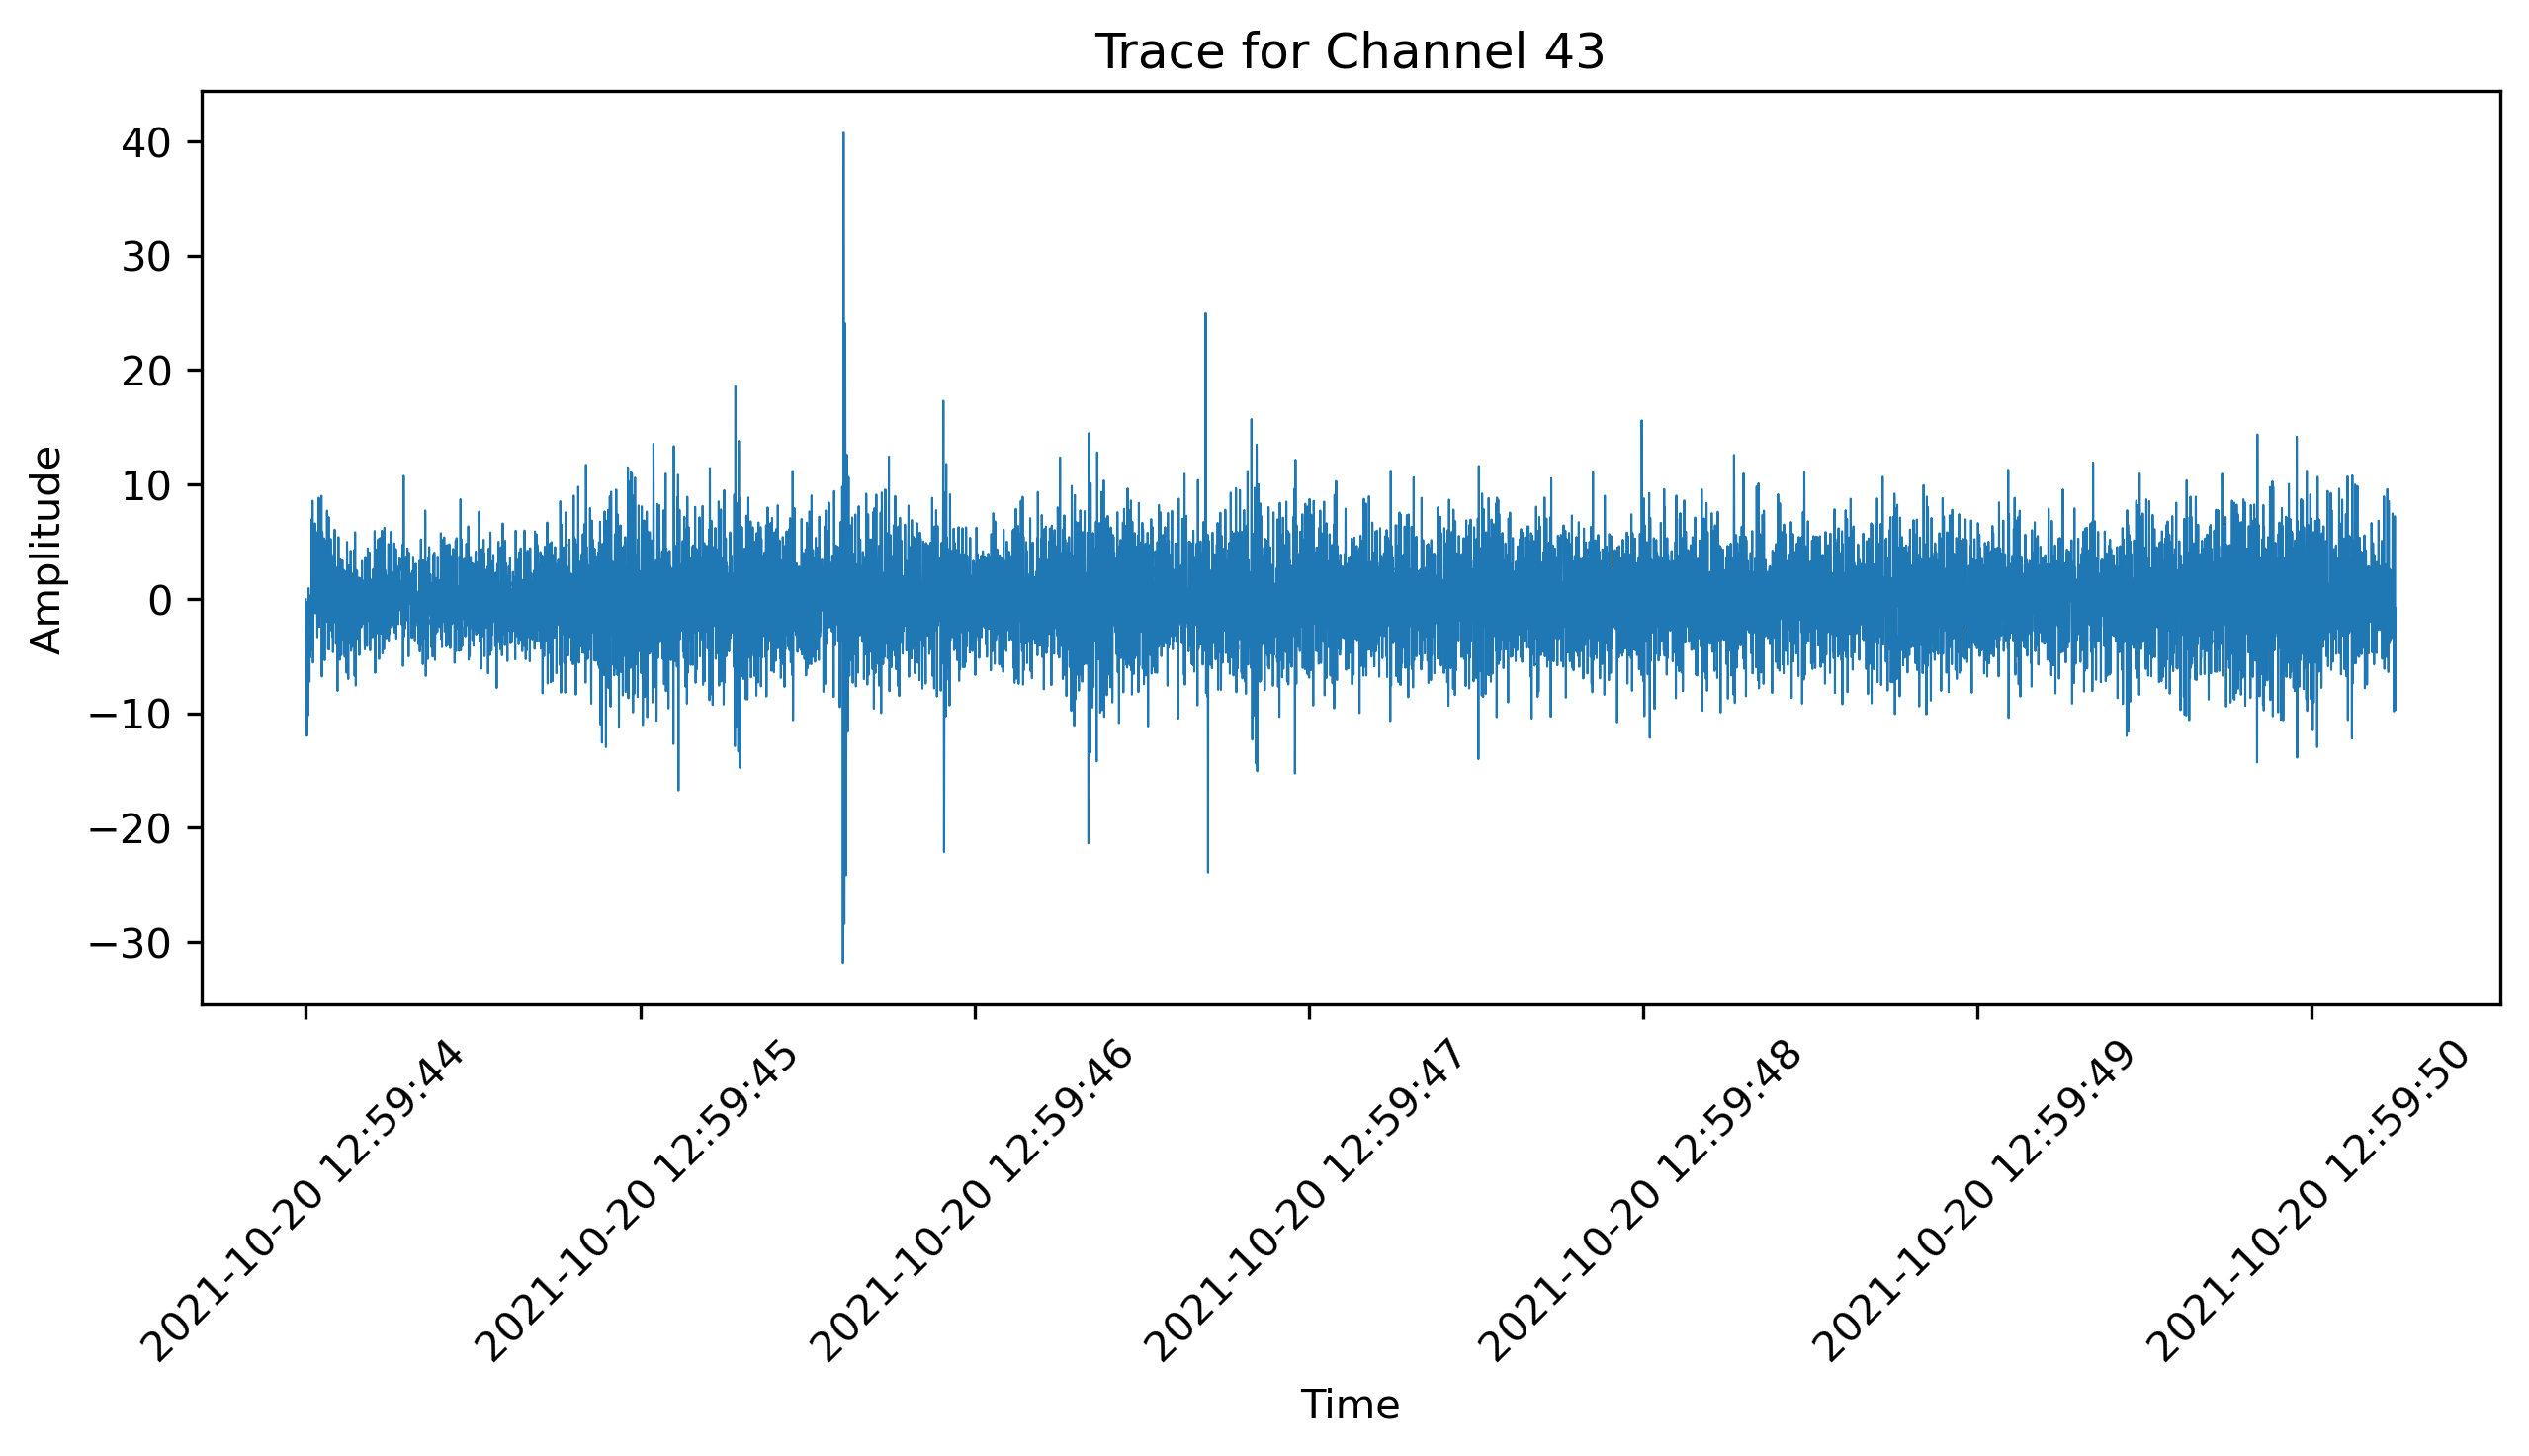

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

channel_id = 43 # ou tout autre numéro de canal valide entre 0 et 519
trace = stream[channel_id]

# Création de la figure
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

# Tracer la forme d'onde pour le canal spécifié
ax.plot(mdates.num2date(trace.times("matplotlib")), trace.data, rasterized=True, lw=0.5)

# Paramètres des axes
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time")
ax.set_title(f"Trace for Channel {channel_id}")

# Formatage des dates sur l'axe des x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

# Affichage du graphique
plt.show()
